Julie Charlton gave this folder to Hein to play around with and learn about how to get the DV from the actual neural spikes data. This file is the copy which I will play around with

In [1]:
import numpy as np

In [1]:
 
import pandas as pd
import numpy as np
from tqdm import tqdm

import os
import scipy.io as sio
 
uberphys_djpath = '/Users/jc2988/Documents/GitHub/uberphys/datajoint'
A324pycellspath = '/Users/jc2988/Documents/GitHub/jcharlton/twoAB/twoAB_cells/A324/20230729'

os.chdir(uberphys_djpath)
from uberphys.utils import bin_monotonic,bin_epochs
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

# Load in the pycells file for 2023-08-07
os.chdir(A324pycellspath)

pycells = sio.loadmat('A324_pycells_20230729.mat', squeeze_me=True, struct_as_record=False)
 


use Q learning model fit q values from 1/13/25 to bin trials by net q value and perform trial-averaged pca
- stay trials only 
- 4 bins of net q 
- start with left hemi ADS
- make a scree plot 

in future code (3/11/25)
- then do both hemis ADS
- then include all trials and see how different it looks 

In [3]:
cpoke_in = pycells['cpoke_in']
violated = pycells['violated']
pokedR = pycells['pokedR']
hemisphere = pycells['filt_hemisphere']
region = pycells['filt_region']
is_hit = pycells['is_hit']
never_cpoked = pycells['never_cpoked']
cpoke_out = pycells['cpoke_out']
spoke = pycells['spoke']
feedback = pycells['feedback']
raw_spike_times = pycells['filt_spike_time']   

viol_mask = (violated != 1) & (never_cpoked==0) 
non_violated_cpokein = cpoke_in[viol_mask]
non_violated_pokedR = pokedR[viol_mask]
non_violated_is_hits = is_hit[viol_mask]
non_violated_spoke = spoke[viol_mask]
non_violated_cpoke_out = cpoke_out[viol_mask]   

stay_mask = np.zeros_like(non_violated_pokedR, dtype=bool)
stay_mask[1:] = non_violated_pokedR[1:] == non_violated_pokedR[:-1]

stay_cpoke_in = non_violated_cpokein[stay_mask]
stay_pokedR = non_violated_pokedR[stay_mask]
stay_is_hit = non_violated_is_hits[stay_mask]
n_stay_trials = len(stay_cpoke_in)

# Convert times to ms so that i can use ints instead of floats

window_start = stay_cpoke_in[:]*1000 - 1000 # starting 1 sec before cpoke in #
window_start = window_start.astype(int)  
window_dur = 2500
window_end = window_start[:] + int(window_dur)  
bin_size = 50# 50 ms bins


edges = list(map(list, zip(window_start, window_end)))

edges_50ms = []
for edge in edges:
    edges_50ms.append(np.arange(edge[0],edge[1],bin_size))# 50 ms bins

# bin spikes

bin_counts = [bin_epochs(dat,edges_50ms) for dat in tqdm(raw_spike_times*1000)]

np.array(bin_counts).shape

windowdiff = window_end-window_start

bin_counts = np.array(bin_counts)

# Create a boolean mask for bad units
bad_units_mask = (region == 'unknown') | \
                 (region == 'CC') |\
                 (hemisphere == 'right') # filter out right hemi 
                

# Use the mask to filter out bad units
filtered_regions = region[~bad_units_mask]
filtered_hemisphere = hemisphere[~bad_units_mask]   

# Use the mask to filter out bad units in bin counts
filtered_bin_counts = bin_counts[~bad_units_mask,:,:]
n_all_units = filtered_bin_counts.shape[0]

# 
filtered_bin_counts = np.array(filtered_bin_counts, dtype=float)

# Get all counts on switch trials only
all_counts = filtered_bin_counts

# Get all counts on switch trials only
leftADS_mask = (filtered_regions == 'ADS')       
leftADS_counts = filtered_bin_counts[leftADS_mask,:,:]


100%|██████████| 1005/1005 [00:01<00:00, 528.08it/s]


In [4]:
# Compute mean and standard deviation, ignoring NaNs
mean_counts = np.nanmean(leftADS_counts, axis=1)[:, None]
std_counts = np.nanstd(leftADS_counts, axis=1)[:, None]

# Handle zero standard deviation by replacing with a small number
std_counts[std_counts == 0] = 1e-10

# Compute z-scores
zscore_counts = (leftADS_counts - mean_counts) / std_counts


In [5]:
folder_path = '/Users/jc2988/Documents/GitHub/jcharlton/twoAB/fit_model_params'
os.chdir(folder_path)
A324_qfit = pd.read_pickle('2025_01_13_A324_simple_perseveration_modelfit.pkl')
A324_fit_alphaQ = A324_qfit['A324_fit_alphaQ'] 

# Calculate the q value on every trial (according to the fit saved on 1/13/25)
actions = non_violated_pokedR.astype(int) 
rewards = non_violated_is_hits.astype(int)
ntrials = len(actions)
Q = np.array([0.5, 0.5])
Qs = np.zeros((ntrials, 2))


for i in range(ntrials-1):
    a = actions[i]
    r = rewards[i]
    Q[a] = Q[a] + A324_fit_alphaQ * (r - Q[a])
    Qs[i+1] = Q.copy()

stayQs = Qs[stay_mask]

# now bin the stay trials by their net Q values 
netstayQ = stayQs[:,1] - stayQs[:,0]
Qbins = np.linspace(-1,1,5)
netstayQbin_labels = np.digitize(netstayQ, Qbins)
print(netstayQbin_labels)



[4 4 4 3 3 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 3 4 4 4 4
 4 4 4 4 4 4 3 3 2 1 2 1 1 1 1 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 2 2 1 2 1 1 1 2 1 1 2 1 1 1 2 1 2 2 2 2 2 2 1 1 2 2 1 3 3 2 3 4 4
 4 4 4 4 4 3 3 3 3 4 4 3 4 4 4 4 3 2 2 3 3 4 3 3 2 1 2 1 1 2 1 2 1 2 2 3 3
 4 3 4 4 4 4 4 4 3 2 2 2 1 1 2 2 2 2 2 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 2 1 1 2 1 1 1 2 1 1 2 2 2 2 2
 2 1 1 1 2 2 3 4 4 3 2 2 1 2 2 2 2 2 3 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 2 1 1 1 1 2 1 1 1 2 3 2 1 1 2 3 2 1 2 2 2 3 2 1 1 2 3 3 4 4 4 4 4 4
 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 4 4 4 4 4 4 3 3 3 4 4 4 4 4 4 4 2 2
 2 2 2 3 2 2 3 3 2 3 2 3 2 2 3 3 2 2 2 3 3 2 2 1 1 1 1 1 1 1 1 1 1 2 1 2 1
 1 1 1 1 2 1 2 3 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 3
 2 2 3 2 2 2 2 3 3 3 3 3 2 2 2 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 3 3 3 4 3 3 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 2 1 2 1 1 2 1 1 1 1 1 1 1
 1 2 2 1 2 1 1 1 1 1 1 1 

Now average trials according to their net q bin

In [7]:
print((netstayQbin_labels).shape)

(539,)


In [8]:
zscore_counts.shape

(105, 539, 24)

In [14]:
bin1avg = np.nanmean(zscore_counts[:,netstayQbin_labels==1,:],axis=1)
print(bin1avg.shape) # now this is each unit's trial averaged z scored activity within bin 1 net q values
bin2avg = np.nanmean(zscore_counts[:,netstayQbin_labels==2,:],axis=1)
bin3avg = np.nanmean(zscore_counts[:,netstayQbin_labels==3,:],axis=1)
bin4avg = np.nanmean(zscore_counts[:,netstayQbin_labels==4,:],axis=1)

(105, 24)


now concatenate the trial averages

In [15]:
trialavgs = np.hstack((bin1avg,bin2avg,bin3avg,bin4avg))    

In [16]:
trialavgs.shape

(105, 96)

do PCA

In [17]:

leftADS_PCA = PCA(n_components=25)
leftADS_counts_new = leftADS_PCA.fit_transform(trialavgs.T) # transform data


make plots

In [21]:
leftADSprojcomponent1 = leftADS_counts_new[:,0]    
leftADSprojcomponent2 = leftADS_counts_new[:,1]
leftADSprojcomponent3 = leftADS_counts_new[:,2]
leftADSprojcomponent4 = leftADS_counts_new[:,3]
leftADSprojcomponent5 = leftADS_counts_new[:,4]
leftADSprojcomponent6 = leftADS_counts_new[:,5]

trial_leftADSprojcomponent1 = leftADSprojcomponent1.reshape(4,24)
trial_leftADSprojcomponent2 = leftADSprojcomponent2.reshape(4,24)
trial_leftADSprojcomponent3 = leftADSprojcomponent3.reshape(4,24)
trial_leftADSprojcomponent4 = leftADSprojcomponent4.reshape(4,24)
trial_leftADSprojcomponent5 = leftADSprojcomponent5.reshape(4,24)
trial_leftADSprojcomponent6 = leftADSprojcomponent6.reshape(4,24)


In [23]:
trial_leftADSprojcomponent1.shape

(4, 24)

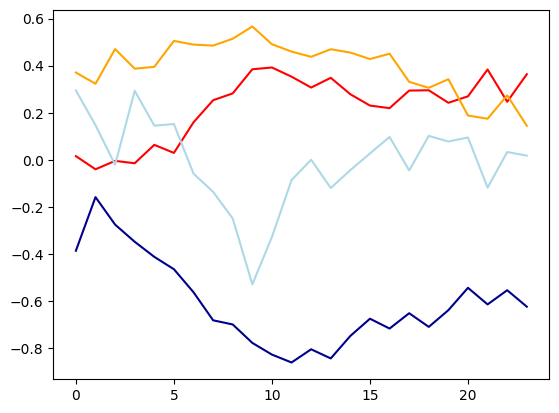

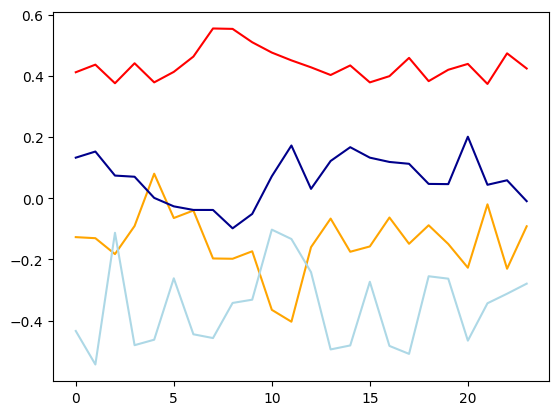

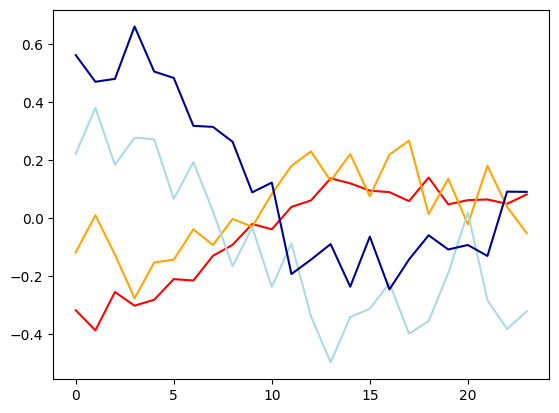

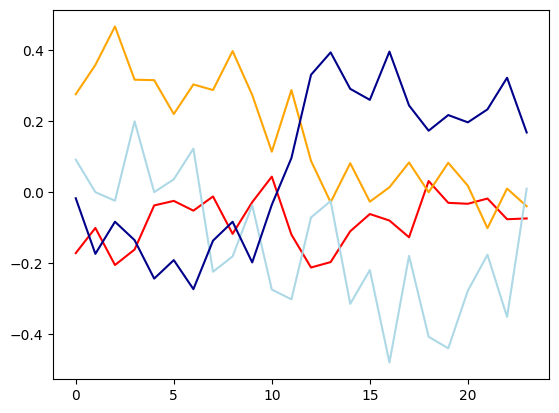

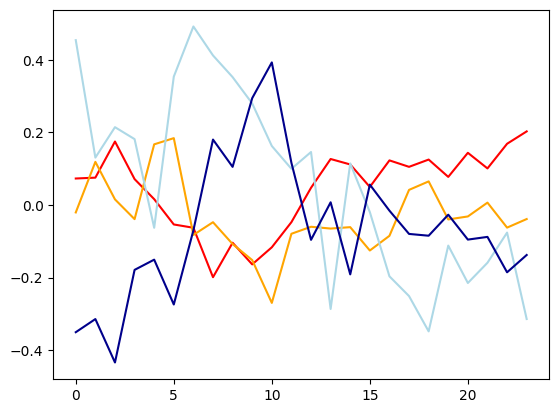

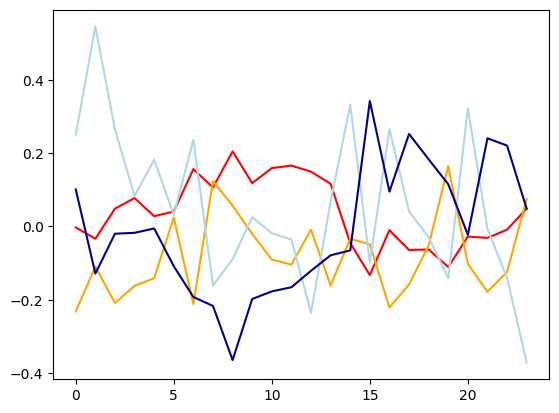

In [27]:
plt.plot(trial_leftADSprojcomponent1[0,:], color='red')
plt.plot(trial_leftADSprojcomponent1[1,:], color='orange')
plt.plot(trial_leftADSprojcomponent1[2,:], color='lightblue')
plt.plot(trial_leftADSprojcomponent1[3,:], color = 'darkblue')
plt.show()

plt.plot(trial_leftADSprojcomponent2[0,:], color='red')
plt.plot(trial_leftADSprojcomponent2[1,:], color='orange')
plt.plot(trial_leftADSprojcomponent2[2,:], color='lightblue')
plt.plot(trial_leftADSprojcomponent2[3,:], color = 'darkblue')
plt.show()

plt.plot(trial_leftADSprojcomponent3[0,:], color='red')
plt.plot(trial_leftADSprojcomponent3[1,:], color='orange')
plt.plot(trial_leftADSprojcomponent3[2,:], color='lightblue')
plt.plot(trial_leftADSprojcomponent3[3,:], color = 'darkblue')
plt.show()

plt.plot(trial_leftADSprojcomponent4[0,:], color='red')
plt.plot(trial_leftADSprojcomponent4[1,:], color='orange')
plt.plot(trial_leftADSprojcomponent4[2,:], color='lightblue')
plt.plot(trial_leftADSprojcomponent4[3,:], color = 'darkblue')
plt.show()

plt.plot(trial_leftADSprojcomponent5[0,:], color='red')
plt.plot(trial_leftADSprojcomponent5[1,:], color='orange')
plt.plot(trial_leftADSprojcomponent5[2,:], color='lightblue')
plt.plot(trial_leftADSprojcomponent5[3,:], color = 'darkblue')
plt.show()

plt.plot(trial_leftADSprojcomponent6[0,:], color='red')
plt.plot(trial_leftADSprojcomponent6[1,:], color='orange')
plt.plot(trial_leftADSprojcomponent6[2,:], color='lightblue')
plt.plot(trial_leftADSprojcomponent6[3,:], color = 'darkblue')
plt.show()




/var/folders/5k/pff9ts0j0jn2nmnnxqwrk_zr0000gq/T/ipykernel_87409/2594814588.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


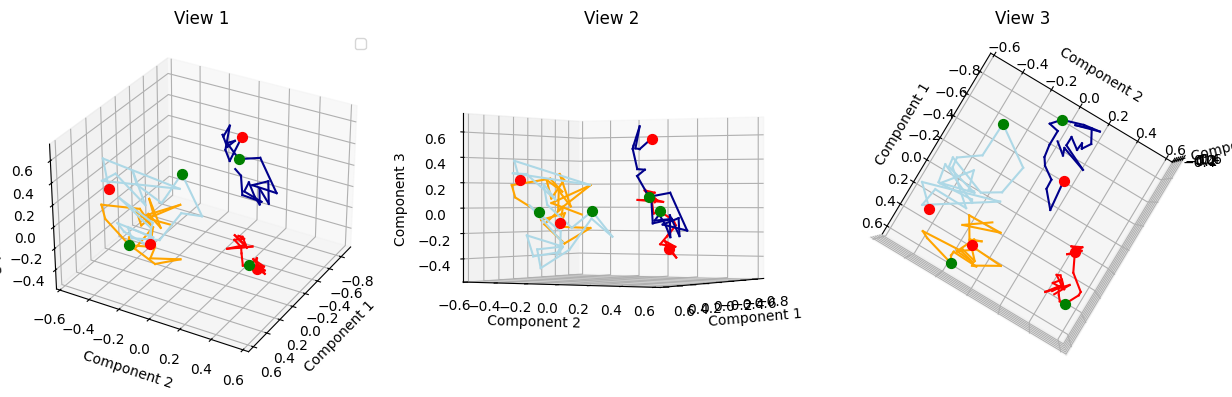

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm

# Create a new figure with multiple subplots
fig = plt.figure(figsize=(15, 5))

# Define viewing angles
view_angles = [(30, 30), (0, 30), (90, 30)]

# Create subplots for each view
axes = [fig.add_subplot(1, len(view_angles), idx + 1, projection='3d') for idx in range(len(view_angles))]

colors = ['red', 'orange', 'lightblue', 'darkblue']


for trial in range(4):
    # Example data (replace this with your actual data)
    trial_leftADSprojcomponent1_bin = trial_leftADSprojcomponent1[trial,:]   
    trial_leftADSprojcomponent2_bin = trial_leftADSprojcomponent2[trial,:]    
    trial_leftADSprojcomponent3_bin = trial_leftADSprojcomponent3[trial,:]     

    # Normalize the index for colormap
     

    # Plot the data in 3D with colors based on the order for each view
    for idx, ax in enumerate(axes):
        for i in range(len(trial_leftADSprojcomponent1_bin) - 1):
            colorchoice = ['red','orange','lightblue','darkblue']
            ax.plot(trial_leftADSprojcomponent1_bin[i:i+2], 
                    trial_leftADSprojcomponent2_bin[i:i+2], 
                    trial_leftADSprojcomponent3_bin[i:i+2], 
                    color=colors[trial])

        # Plot a red point at the first index
        ax.scatter(trial_leftADSprojcomponent1_bin[0], 
                   trial_leftADSprojcomponent2_bin[0], 
                   trial_leftADSprojcomponent3_bin[0], 
                   color='red', s=50)

        # Plot a green point at cpoke in 
        ax.scatter(trial_leftADSprojcomponent1_bin[9], 
                   trial_leftADSprojcomponent2_bin[9], 
                   trial_leftADSprojcomponent3_bin[9], 
                   color='green', s=50)

        

# Set labels and titles for each subplot
for idx, ax in enumerate(axes):
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    ax.set_title(f'View {idx + 1}')
    ax.view_init(elev=view_angles[idx][0], azim=view_angles[idx][1])
    if idx == 0:
        ax.legend()

# Show the plot
plt.show()

/var/folders/5k/pff9ts0j0jn2nmnnxqwrk_zr0000gq/T/ipykernel_87409/3587152446.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


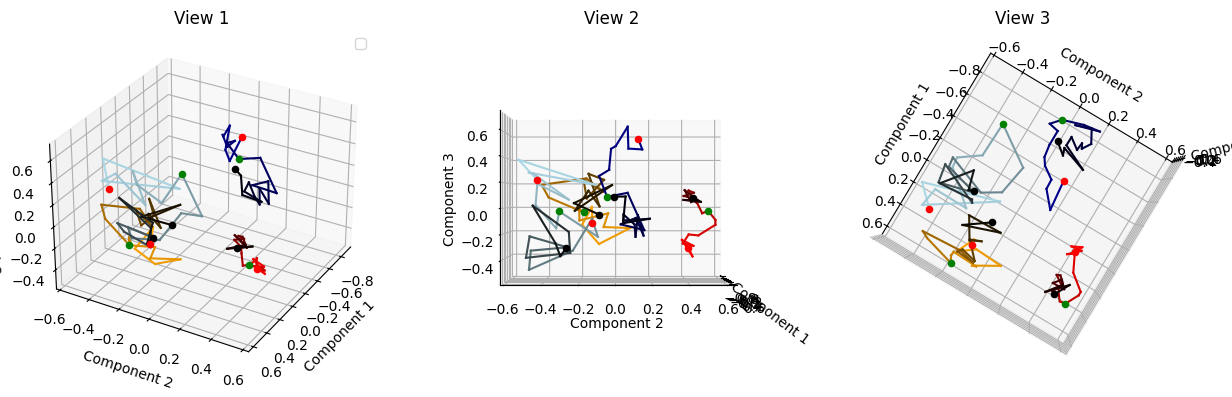

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.colors import Normalize, to_rgba

# Create a new figure with multiple subplots
fig = plt.figure(figsize=(15, 5))

# Define viewing angles
view_angles = [(30, 30), (0, 0), (90, 30)]

# Create subplots for each view
axes = [fig.add_subplot(1, len(view_angles), idx + 1, projection='3d') for idx in range(len(view_angles))]

# Define base colors for each trial
base_colors = ['red', 'orange', 'lightblue', 'darkblue']

for trial in range(4):
    # Example data (replace this with your actual data)
    trial_leftADSprojcomponent1_bin = trial_leftADSprojcomponent1[trial, :]
    trial_leftADSprojcomponent2_bin = trial_leftADSprojcomponent2[trial, :]
    trial_leftADSprojcomponent3_bin = trial_leftADSprojcomponent3[trial, :]

    # Normalize the index for colormap
    norm = Normalize(vmin=0, vmax=len(trial_leftADSprojcomponent1_bin) - 1)
    cmap = plt.get_cmap('Greys')

    # Get the base color for the current trial
    base_color = to_rgba(base_colors[trial])

    # Plot the data in 3D with colors based on the order for each view
    for idx, ax in enumerate(axes):
        for i in range(len(trial_leftADSprojcomponent1_bin) - 1):
            # Get the shade from the colormap
            shade = cmap(norm(i))
            # Blend the base color with the shade
            blended_color = [base_color[j] * shade[j] for j in range(3)] + [base_color[3]]
            ax.plot(trial_leftADSprojcomponent1_bin[i:i+2], 
                    trial_leftADSprojcomponent2_bin[i:i+2], 
                    trial_leftADSprojcomponent3_bin[i:i+2], 
                    color=blended_color)

        # Plot a red point at the first index
        ax.scatter(trial_leftADSprojcomponent1_bin[0], 
                   trial_leftADSprojcomponent2_bin[0], 
                   trial_leftADSprojcomponent3_bin[0], 
                   color='red', s=20)

        # Plot a green point at cpoke in 
        ax.scatter(trial_leftADSprojcomponent1_bin[9], 
                   trial_leftADSprojcomponent2_bin[9], 
                   trial_leftADSprojcomponent3_bin[9], 
                   color='green', s=20)

        # plot a black point at the last index
        ax.scatter(trial_leftADSprojcomponent1_bin[-1], 
                   trial_leftADSprojcomponent2_bin[-1], 
                   trial_leftADSprojcomponent3_bin[-1], 
                   color='black', s=20)

# Set labels and titles for each subplot
for idx, ax in enumerate(axes):
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    ax.set_title(f'View {idx + 1}')
    ax.view_init(elev=view_angles[idx][0], azim=view_angles[idx][1])
    if idx == 0:
        ax.legend()

# Show the plot
plt.show()

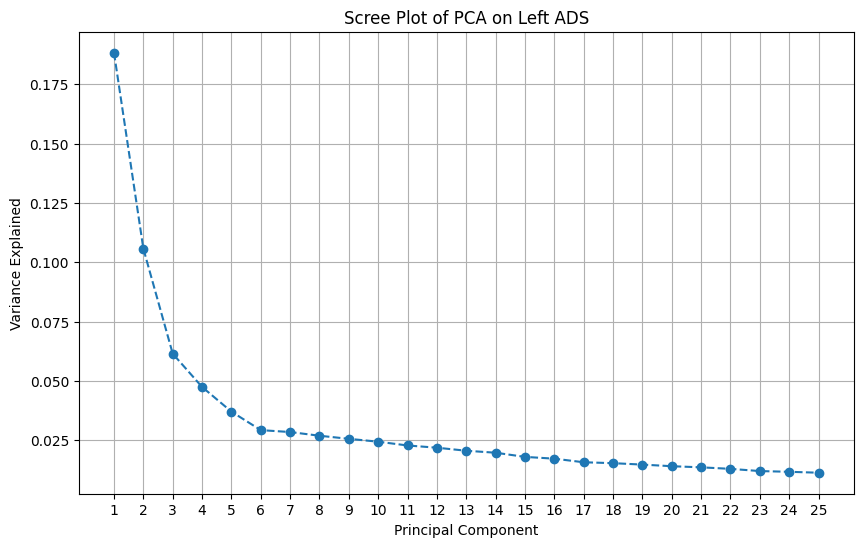

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


leftADS_PCA = PCA(n_components=25)
leftADS_PCA.fit(trialavgs.T)

# Extract the explained variance ratio
explained_variance_ratio = leftADS_PCA.explained_variance_ratio_

# Create a scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot of PCA on Left ADS')  
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid()
plt.show()